# Lit MD
Literature review in mark down. Make notes in a markdown document as you read papers, mark them with a few simple tags and make it easy to compile these documents into a review based on their user defined tags.

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
import itertools

%load_ext rpy2.ipython

C:\Users\david\Miniconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
papers = os.listdir("papers")

# All tags

In [3]:
tag_list = list()

for paper in papers:
    print(paper)
    file = "papers/" + paper
    with open(file, "r") as f:
        lines=f.readlines()
    #Index of tag start and end
    tagi = [i for i,line in enumerate(lines) if "tags" in line]
    tags = lines[tagi[0]+1 : tagi[-1]]
    #Remove new line character
    tags = [tag[:-1] for tag in tags]
    tag_list.append(tags)# = tag_list + tags
    
#Flatten tag_list
flat_tag_list = [tag for paper_tags in tag_list for tag in paper_tags]

A Beginner’s Guide to Phylogenetics.md
A comparison of association methods for cytotoxicity mapping in pharmacogenomics.md
A Double-Inactivated Severe Acute Respiratory Syndrome Coronavirus Vaccine Provides Incomplete Protection in Mice and Induces Increased Eosinophilic Proinflammatory Pulmonary Response upon Challenge.md
A General Empirical Model of Protein Evolution Derived from Multiple Protein Families Using a Maximum-Likelihood Approach.md
A pan-coronavirus fusion inhibitor targeting the HR1 domain of human coronavirus spike.md
A Phylogeny-Based Global Nomenclature System and Automated Annotation Tool for H1 Hemagglutinin Genes from Swine Influenza A Viruses.md
A pneumonia outbreak associated with a new coronavirus of probable bat origin.md
A SARS-CoV-2 Vaccination Strategy Focused on Population-Scale Immunity.md
A sequence homology and bioinformatic approach can predict candidate targets for immune responses to SARS-CoV-2.md
Accurate Reconstruction of Insertion-Deletion Historie

In [4]:
alphabetised_list = pd.Series(flat_tag_list).value_counts().sort_index()
print(alphabetised_list)
alphabetised_list.to_csv("tag_summary.csv", header=False)

ADE                               2
MHC processing                    4
ancestral_reconstruction          8
antibody                          4
antigen                          12
assay_prediction                  5
corona virus                      2
coronavirus                      33
epitope                          10
epitope prediction                5
flu-vaccine                      11
flu_evolution                     3
flu_vaccine                       1
hemagglutinin                     4
immune correlates                 1
immune response                   9
indels                            4
machine learning                  4
machine_learning                 14
phylogenetic non-independence     1
phylogenetics                     7
sequence_alignment                3
statistics                        3
substitution_matrix               2
vaccine                           6
vaccine design                   14
virus evolution                   4
zoonotic disease            

# Create review
Specify a list of tags to keep for the review.

In [5]:
review_name = "test"
review_name = "reviews/%s.md" %(review_name)
keep_tags = ["coronavirus", "immune response", "corona virus"]

In [6]:
#Print paper names
for paper in papers:
    file = "papers/" + paper
    with open(file, "r") as f:
        lines=f.readlines()
    #Index of tag start and end
    tagi = [i for i,line in enumerate(lines) if "tags" in line]
    tags = lines[tagi[0]+1 : tagi[-1]]
    #Remove new line character
    tags = [tag[:-1] for tag in tags]
    tag_list = tag_list + tags
    if any(tag in keep_tags for tag in tags):
        print(paper,"\n", tags,"\n")

A Double-Inactivated Severe Acute Respiratory Syndrome Coronavirus Vaccine Provides Incomplete Protection in Mice and Induces Increased Eosinophilic Proinflammatory Pulmonary Response upon Challenge.md 
 ['coronavirus', 'vaccine'] 

A pan-coronavirus fusion inhibitor targeting the HR1 domain of human coronavirus spike.md 
 ['coronavirus', 'vaccine design'] 

A pneumonia outbreak associated with a new coronavirus of probable bat origin.md 
 ['coronavirus'] 

A SARS-CoV-2 Vaccination Strategy Focused on Population-Scale Immunity.md 
 ['coronavirus', 'vaccine design'] 

A sequence homology and bioinformatic approach can predict candidate targets for immune responses to SARS-CoV-2.md 
 ['coronavirus', 'vaccine design', 'epitope', 'epitope prediction'] 

Adaptation of SARS coronavirus to humans.md 
 ['coronavirus', 'zoonotic disease'] 

An effective CTL peptide vaccine for ebola Zaire based on survivors CD8+ targeting of a particular nucleocapsid protein epitope with potential implications 

In [7]:
with open("reviews/test.md", "w") as review:
    review.write("# Review of: %s\n" %(", ".join(keep_tags)))
        
for paper in papers:
    file = "papers/" + paper
    with open(file, "r") as f:
        lines=f.readlines()
    #Index of tag start and end
    tagi = [i for i,line in enumerate(lines) if "tags" in line]
    tags = lines[tagi[0]+1 : tagi[-1]]
    #Remove new line character
    tags = [tag[:-1] for tag in tags]
    if any(tag in keep_tags for tag in tags):
        with open("reviews/test.md", "a") as review:
            review.writelines(lines)
            review.write("\n")

# Knowledge graph
Create a network graph of the tags and their conections to each other.

In [8]:
#Format data

#unique tags
utag = set(flat_tag_list)
#Create a dataframe listing all possible pairs and the number of times that pair occurs
tag_pairs = pd.DataFrame(list(itertools.combinations(utag, 2)),
                         columns = ['tag1', 'tag2'])
tag_pairs['links'] = 0

# count the number of occurences of each pair
for paper_tags in tag_list:
    within_paper_combinations = list(itertools.combinations(paper_tags, 2))
    for pair in within_paper_combinations:
        tag_pairs.loc[tag_pairs.tag1.isin(pair) & tag_pairs.tag2.isin(pair),'links'] += 1

tag_edges = tag_pairs[tag_pairs.links>0]
tag_edges['links_weight'] = tag_edges.links*2
tag_nodes = pd.Series(flat_tag_list).value_counts()

C:\Users\david\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


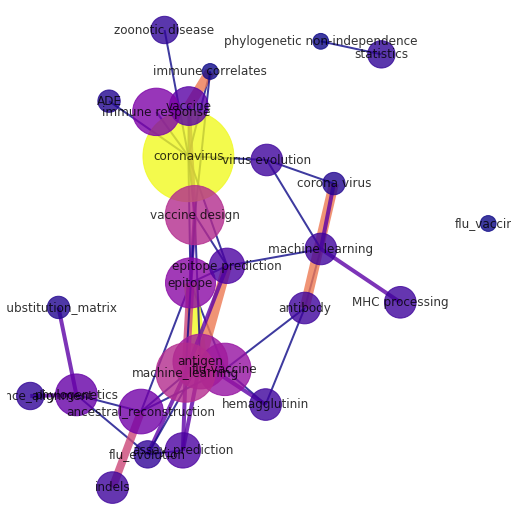

In [9]:
#Change plot size
plt.rcParams["figure.figsize"] = (7,7)

#Create a graph of the tag_pairs
netplot = nx.from_pandas_edgelist(tag_edges, "tag1", "tag2", ['links','links_weight'])
#Add nodes which have no connections
netplot.add_nodes_from(tag_nodes.index)
#Update nodes dataframe to match the graph order so we can use the counts
tag_nodes = tag_nodes.reindex(netplot.nodes())

nx.draw(netplot, with_labels=True, font_size=12,
    #edges
    edge_color=tag_edges.links, width=tag_edges.links*2, edge_cmap=plt.cm.plasma,
    #nodes
    node_size=tag_nodes*1000, node_shape=".", alpha=0.8, node_color=tag_nodes, cmap=plt.cm.plasma,
    #layout
    pos=nx.spring_layout(netplot, iterations=1000, scale=50, k=10, weight='links_weight'))

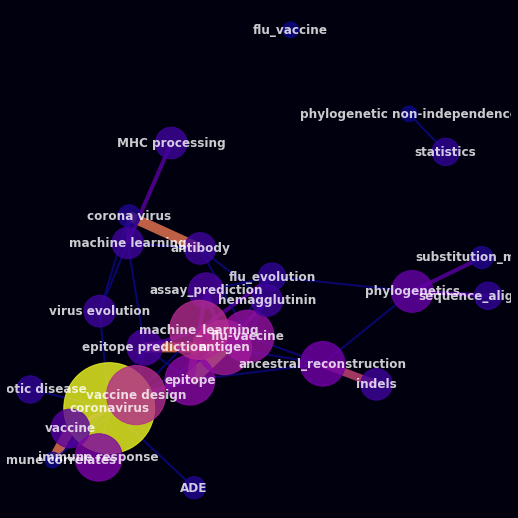

In [10]:
#Change plot size
plt.rcParams["figure.figsize"] = (7,7)

#Create a graph of the tag_pairs
netplot = nx.from_pandas_edgelist(tag_edges, "tag1", "tag2", ['links','links_weight'])
#Add nodes which have no connections
netplot.add_nodes_from(tag_nodes.index)
#Update nodes dataframe to match the graph order so we can use the counts
tag_nodes = tag_nodes.reindex(netplot.nodes())

fig = plt.figure()
nx.draw(netplot,
    #labels    
    with_labels=True, font_size=12, font_color="white", font_weight="bold",
    #edges
    edge_color=tag_edges.links, width=tag_edges.links*2, edge_cmap=plt.cm.plasma,
    #nodes
    node_size=tag_nodes*1000, node_shape=".", alpha=0.8, node_color=tag_nodes, cmap=plt.cm.plasma,
    #layout
    pos=nx.spring_layout(netplot, iterations=1000, scale=50, k=10, weight='links_weight'))
fig.set_facecolor("#00000f")

In [11]:
#Save data for importing into R
tag_edges.to_csv("litmd_edges.csv", index=False)
tag_nodes = tag_nodes.reset_index()
tag_nodes.columns = ["name", "count"]
tag_nodes.to_csv("litmd_nodes.csv", index=False)

In [12]:
%%R
library(networkD3)

#Load data
tag_nodes <- read.csv("litmd_nodes.csv")
tag_edges <- read.csv("litmd_edges.csv")

#Reformat
tag_nodes <- tag_nodes[order(tag_nodes$name),]
rownames(tag_nodes) <- 1:nrow(tag_nodes)
tag_edges$tagn1 <- match(tag_edges$tag1, tag_nodes$name)-1
tag_edges$tagn2 <- match(tag_edges$tag2, tag_nodes$name)-1

tag_nodes$group <- cut(tag_nodes$count, 3)

#Plot
forceNetwork(Links=tag_edges, Nodes=tag_nodes,
            Source='tagn1', Target='tagn2', Value='links',
            NodeID='name', Group='group', Nodesize='count',
            radiusCalculation = JS("(d.nodesize)+6"), linkDistance = 100,
             opacity=0.8, fontSize=20, charge =-50, legend=T)